In [75]:
import pandas as pd
import numpy as np
import requests
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
import time
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.pipeline import Pipeline

In this project, I will build a classification model that will predict whether a reddit post, with only the title and text content provided, is in the World of Warcraft (WoW) subreddit or the Final Fantasy XIV (FFXIV) subreddit.  
I am approaching the problem from the perspective of part of the marketing team at Square Enix, the publisher of FFXIV.  With this model, we may uncover language that our players use more frequently than those who enjoy our prime competitor, so we can better craft our marketing to appeal to our customers.

# Pushshift scraping!

The first thing we need is to use pushshift to grab our posts.  I built a function to grab 100 posts from every month from each subreddit, going back to the founding of the FFXIV subreddit (which, oddly enough, happens to be 10 years ago almost to the day!)

In [76]:
def posts_getter(subreddit):
    #using https://www.epochconverter.com/ I converted the current date 
    #and dates of the FFXI subreddit's founding (ffxiv is younger, so this way we'll have a more equal split)
    current_epoch = 1611872155
    founding_epoch = 1454019344
    one_month_in_seconds = 2628288
    url = 'https://api.pushshift.io/reddit/search/submission'
    posts = []
    #iterates, month by month, from the founding of the r/ffxiv to january 28, 2021, pulling 100 posts every month.
    #this spread of time helps ensure that there are no duplicate posts, and also gives us a very wide view of each subreddit
    time.sleep(15)
    for month in range(founding_epoch, current_epoch, one_month_in_seconds):
        res = requests.get(url, {'subreddit': subreddit, 'size': 100, 'before': month})
        try:
            data = res.json()
            posts.extend(data['data'])
        except:
            pass
        #for equity in post counts between the two subreddits, I stop them both once they exceed 2500.
        if len(posts) > 2500:
            break
    return posts
#gets the posts
ffxiv_posts = posts_getter('ffxiv')
wow_posts = posts_getter('wow')
#turns those posts into a dataframe
ffxiv_df = pd.DataFrame(ffxiv_posts)
wow_df = pd.DataFrame(wow_posts)
print('ffxiv shape is',ffxiv_df.shape)
print('wow shape is ',wow_df.shape)

ffxiv shape is (2500, 98)
wow shape is  (2600, 94)


We now have our two dataframes! Let's put them together!  I don't need to fret over differences in columns, since we only need three columns from them anyways.

In [77]:
df = pd.concat([ffxiv_df, wow_df], axis = 0)

Normally, I'd leave the below uncommented in order to save the dataframe.  However, I'm commenting it out to make sure I'm calling the same dataframe that I created on Saturday, January 30th.  This keeps my modeling consistent day to day.  If I were to take this into production, I would remove this comment (and a similar comment below that does the same thing once the dataset is clean.)

In [78]:
#df.to_csv('./datasets/concatenated_df.csv', index = False)

df = pd.read_csv('./datasets/concatenated_df.csv')

# Cleaning, tokenizing, and analyzing

Now, I'm turning my subreddit column into a numeric, and renaming it to reflect that.  I could have used get_dummies here as well, but decided to use this method as it makes certain that FFXIV is my positive value.  (This is merely a matter of taste:  I'm an avid FFXIV player.)

In [79]:
df['subreddit'].replace(['ffxiv','wow'],[1,0], inplace = True)
df.rename(columns = {'subreddit':'is_on_ffxiv'}, inplace = True)

Let's do some preliminary cleanings.  First, any null 'selftext' values will be the result of that post being something other than a self text post, such as an image, link, or video.  Thus, I'm replacing those nulls with 'notatextpost', with that string serving as an indicator, and something we can drop later once count vectorization is done.

In [80]:
df.loc[lambda df: df['selftext'].isna() == True] = df.loc[lambda df: df['selftext'].isna() == True].fillna('notatextpost')
print(df['selftext'].isna().sum())

0


Next, I separate the three columns I really need: my features and my target.

In [81]:
df = df[['selftext','title', 'is_on_ffxiv']]

In [82]:
df.isna().sum()

selftext       0
title          0
is_on_ffxiv    0
dtype: int64

In [83]:
df.shape

(5200, 3)

Looks good!  One more cleaning step:  dropping rows where the text was either deleted or removed:  We don't need to see what deleted posts have to say, and we also don't want to include any posts that were removed by a subreddit moderator, as that could lead to spam entering our dataset.

In [84]:
#dropping the rows where the post was removed, by a mod (removed) or the user (deleted).  Doesn't really offer us any good information, and could even give us spam posts that the mods removed.
df.drop(df.loc[lambda df: df['selftext'] == '[removed]'].index, inplace = True)
df.drop(df.loc[lambda df: df['selftext'] == '[deleted]'].index, inplace = True)

Next, in order to get my data ready to model, I use the Snowball Stemmer to get stems of every word in my text posts and my titles.  I chose Snowball Stemmer specifically because of it's language support, and the fact that I can tell it to ignore stop words, which results in a faster runtime.  Those stopwords will get dropped later by CountVectorizer, anyways. This will help save on computational expenses later on as well, since I'll have fewer features from my CountVectorizer.   

In [85]:
#first, tokenize both 'selftext' and 'title' in order to prep them for stemming
def identify_selftext_tokens(row):
    text = row['selftext']
    tokens = word_tokenize(text)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words
def identify_title_tokens(row):
    text = row['title']
    tokens = word_tokenize(text)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

df['self_text_words'] = df.apply(identify_selftext_tokens, axis = 1)
df['title_words'] = df.apply(identify_title_tokens, axis = 1)

df['stemmed_self_text'] = df['self_text_words'].apply(lambda x: [SnowballStemmer("english", ignore_stopwords=True).stem(y) for y in x])
df['stemmed_title'] = df['title_words'].apply(lambda x: [SnowballStemmer("english", ignore_stopwords=True).stem(y) for y in x])

While I'm at it, I also created columns for post length and title length.  This may be nothing, but it's a feature worth investigating.

In [86]:
df['self_text_len'] = df['selftext'].apply(lambda x: len(x.split()))
df['title_len'] = df['title'].apply(lambda x: len(x.split()))

Finally, I use the vader Sentiment Intensity Analyser to analyze both my titles and my self text.

In [87]:
analyzer = SentimentIntensityAnalyzer()
#self text first
df['self_text_vader_neg'] = 0
df['self_text_vader_pos'] = 0
df['self_text_vader_neu'] = 0
df['self_text_vader_compound'] = 0
for i, q in enumerate(df.selftext.values):
    vs = analyzer.polarity_scores(q)
    df.iloc[i, -4] = vs['neg']
    df.iloc[i, -3] = vs['pos']
    df.iloc[i, -2] = vs['neu']
    df.iloc[i, -1] = vs['compound']
#now titles
df['title_vader_neg'] = 0
df['title_vader_pos'] = 0
df['title_vader_neu'] = 0
df['title_vader_compound'] = 0
for i, q in enumerate(df.title.values):
    vs = analyzer.polarity_scores(q)
    df.iloc[i, -4] = vs['neg']
    df.iloc[i, -3] = vs['pos']
    df.iloc[i, -2] = vs['neu']
    df.iloc[i, -1] = vs['compound']

Now, once my stemming, SA, and lengths have all been taken care of, I get rid of the columns I don't need.

In [88]:
df.drop(columns = ['selftext','title','self_text_words','title_words'], inplace = True)

In [89]:
#one last check to make sure our dataframe looks how we want it to
df.head()

,is_on_ffxiv,stemmed_self_text,stemmed_title,self_text_len,title_len,self_text_vader_neg,self_text_vader_pos,self_text_vader_neu,self_text_vader_compound,title_vader_neg,title_vader_pos,title_vader_neu,title_vader_compound
0,1,[notatextpost],"[post, your, favourit, screenshot]",1,4,0.0,0.0,1.0,0.0,0.000,0.000,1.000,0.0000
3,1,[notatextpost],"[have, drawn, anyth, in, like, a, decad, pick,...",1,21,0.0,0.0,1.0,0.0,0.066,0.207,0.727,0.5431
4,1,[notatextpost],"[what, are, the, chanc, the, fate, of, this, n...",1,13,0.0,0.0,1.0,0.0,0.000,0.130,0.870,0.2023
5,1,"[so, a, few, week, ago, there, was, a, new, su...","[ffxiv, survey, realm, pop, etc, look, for]",49,6,0.0,0.0,1.0,0.0,0.000,0.000,1.000,0.0000
6,1,[notatextpost],"[drew, my, pld, and, lalafel, smn]",1,7,0.0,0.0,1.0,0.0,0.000,0.000,1.000,0.0000


It's clean, stemmed, analyzed, and I've got some extra features to work with.  Let's save it to a csv, for consistency.

In [90]:
#df.to_csv('./datasets/stemmed_and_cleaned_df.csv', index = False)

df = pd.read_csv('./datasets/stemmed_and_cleaned_df.csv')

## EDA Visualizations & Feature Engineering

Let's begin the EDA with some basic summary statistics.  We've only got two numeric columns, so let's see what they have to say.

In [91]:
df['self_text_len'].describe()

count    4176.000000
mean       62.377874
std       119.733272
min         1.000000
25%         1.000000
50%        30.000000
75%        76.000000
max      2448.000000
Name: self_text_len, dtype: float64

A high average for post length, and a very high standard deviation.  I suspect that maximum of 4000 is pulling the mean and std higher than they ought to be.

In [92]:
df['title_len'].describe()

count    4176.000000
mean        8.367098
std         5.356964
min         1.000000
25%         5.000000
50%         7.000000
75%        11.000000
max        59.000000
Name: title_len, dtype: float64

While the standard deviation isn't as out of proportion as it is in self-text, there remains a significant outlier in the titles.  Hopefully, I'll see what that's about by examining the distributions.

First, let's see the distributions of our self text lengths and our title lengths.  I'll do one table that includes both subs, and then one table for each of them.

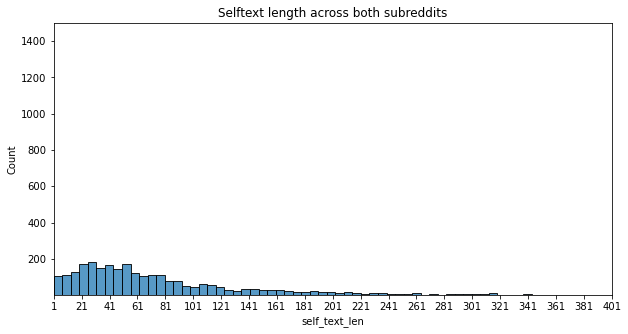

In [93]:
plt.figure(figsize=(10,5))
plt.xlim(1, 400)
plt.ylim(1,1500)
plt.xticks(range(1,420,20))
#exclude all 'notatextpost' and 'deleted' values
plt.title('Selftext length across both subreddits')
sns.histplot(df.loc[df['stemmed_self_text'] != "['notatextpost']"]['self_text_len'], bins = 400);

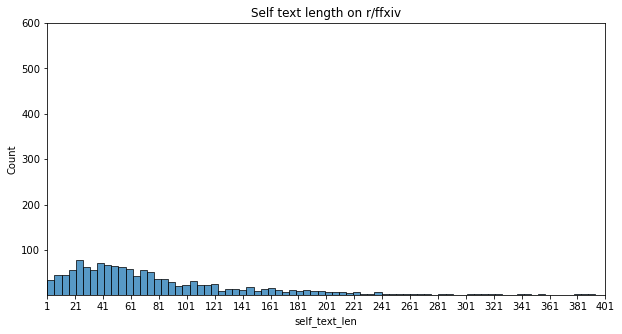

In [94]:
plt.figure(figsize = (10,5))
plt.xlim(1, 400)
plt.ylim(1,600)
plt.xticks(range(1,420,20))
#exclude all 'notatextpost' and 'deleted' values
plt.title('Self text length on r/ffxiv')
sns.histplot(df.loc[df['stemmed_self_text'] != "['notatextpost']"].loc[df['is_on_ffxiv'] == 1]['self_text_len'], bins = 400);

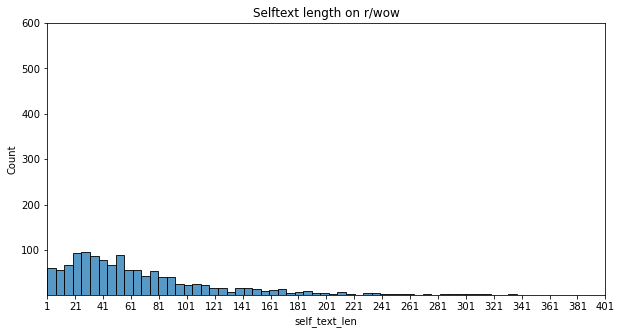

In [95]:
plt.figure(figsize = (10,5))
plt.xlim(1, 400)
plt.ylim(1,600)
plt.xticks(range(1,420,20))
#exclude all 'notatextpost' and 'deleted' values
plt.title('Selftext length on r/wow')
sns.histplot(df.loc[df['stemmed_self_text'] != "['notatextpost']"].loc[df['is_on_ffxiv'] == 0]['self_text_len'], bins = 400);

Many posts with just less than ten words here.  Even after removing deleted, mod-removed, and non-text posts, there's still very many.  A surprising statistic, and it is consistent across both subreddits.   Beyond that, though, the distributions are very similar to eachother.

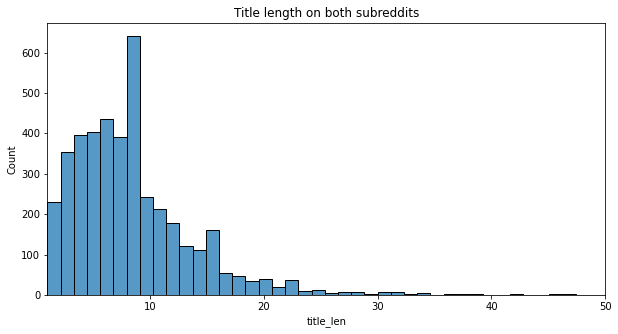

In [96]:
plt.figure(figsize = (10,5))
plt.xlim(1, 50)
plt.title('Title length on both subreddits')
sns.histplot(df['title_len'], bins = 50);

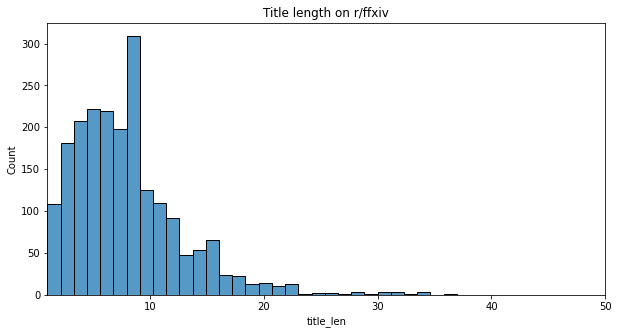

In [97]:
plt.figure(figsize = (10,5))
plt.xlim(1, 50)
plt.title('Title length on r/ffxiv')
sns.histplot(df.loc[df['is_on_ffxiv'] == 1]['title_len'], bins = 50);

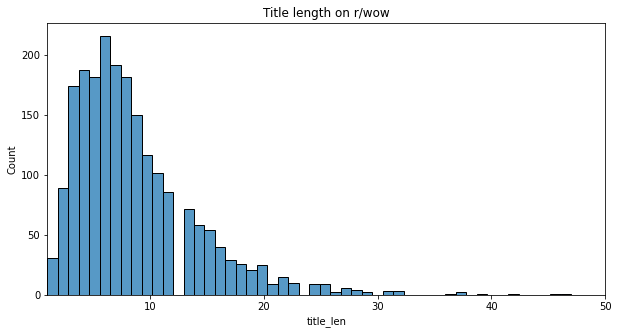

In [98]:
plt.figure(figsize = (10,5))
plt.xlim(1, 50)
plt.title('Title length on r/wow')
sns.histplot(df.loc[df['is_on_ffxiv'] == 0]['title_len'], bins = 50);

Again, these features are almost identical in distribution.  With this information, I'm considering dropping these columns.

Next, I'll examine some box plots to get a better look at those outliers.

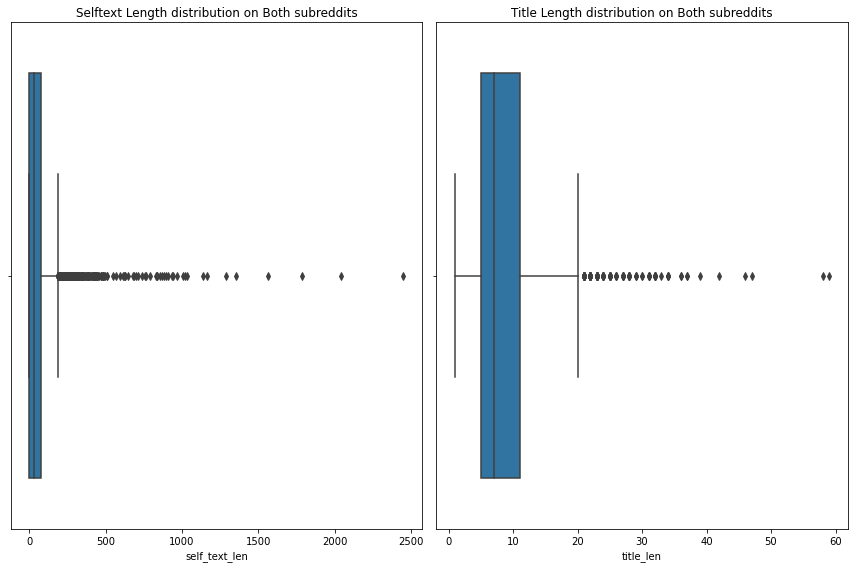

In [99]:
plt.subplot(121)
#plt.figure(figsize = (10,5))
plt.title('Selftext Length distribution on Both subreddits')
sns.boxplot(x= df['self_text_len'])
plt.subplot(122)
plt.title('Title Length distribution on Both subreddits')
sns.boxplot(x= df['title_len'])
plt.tight_layout(rect=(8,8,10,10))

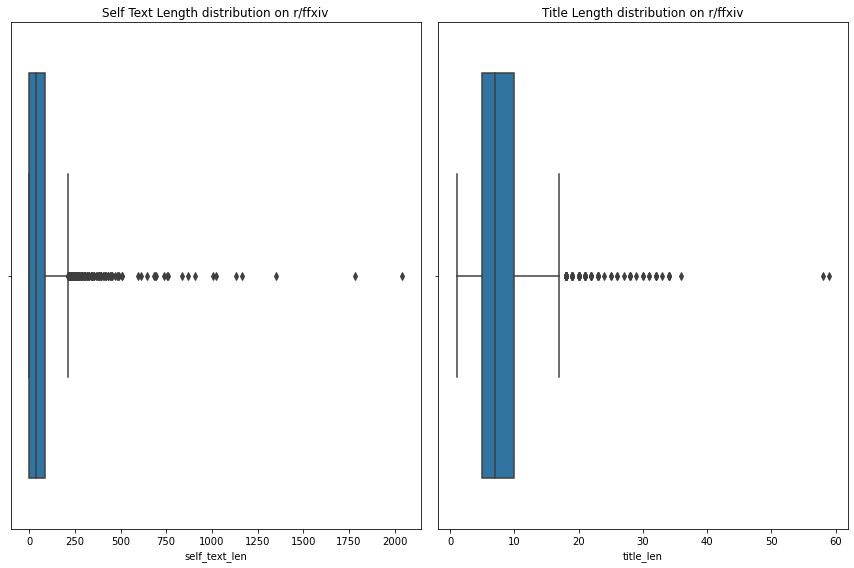

In [100]:
plt.subplot(121)
plt.title('Self Text Length distribution on r/ffxiv')
sns.boxplot(x= df.loc[df['is_on_ffxiv'] == 1]['self_text_len'])
plt.subplot(122)
plt.title('Title Length distribution on r/ffxiv')
sns.boxplot(x= df.loc[df['is_on_ffxiv'] == 1]['title_len'])
plt.tight_layout(rect=(8,8,10,10))

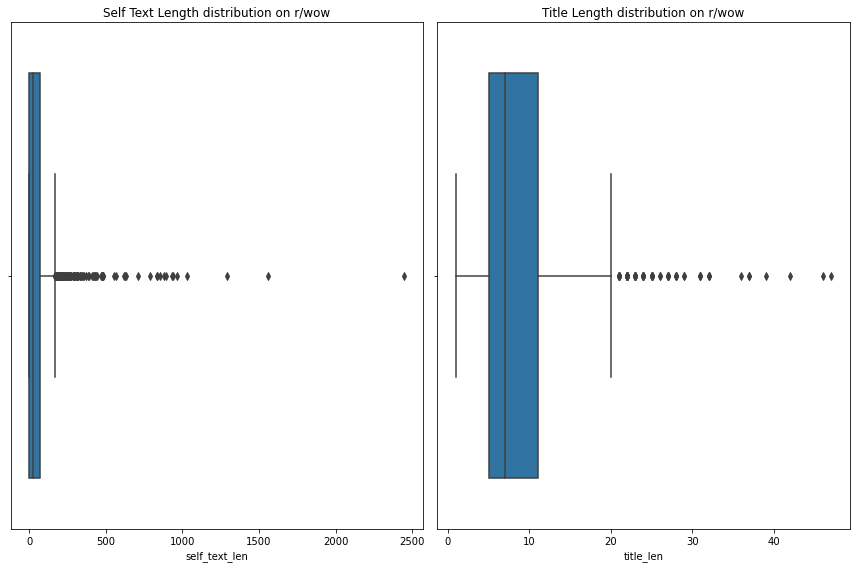

In [101]:
plt.subplot(121)
plt.title('Self Text Length distribution on r/wow')
sns.boxplot(x= df.loc[df['is_on_ffxiv'] == 0]['self_text_len'])
plt.subplot(122)
plt.title('Title Length distribution on r/wow')
sns.boxplot(x= df.loc[df['is_on_ffxiv'] == 0]['title_len'])
plt.tight_layout(rect=(8,8,10,10))

With these boxplots, we can better see the number of outliers in each distribution, and this data only further reinforces my plan to drop the length and title columns from our features.  The only place where a distinct difference is seen is in Title length, and so I think that'll be the only column I keep around.

Next, I want to examine the distributions of all my Vader scores, both on the whole and on each subreddit.

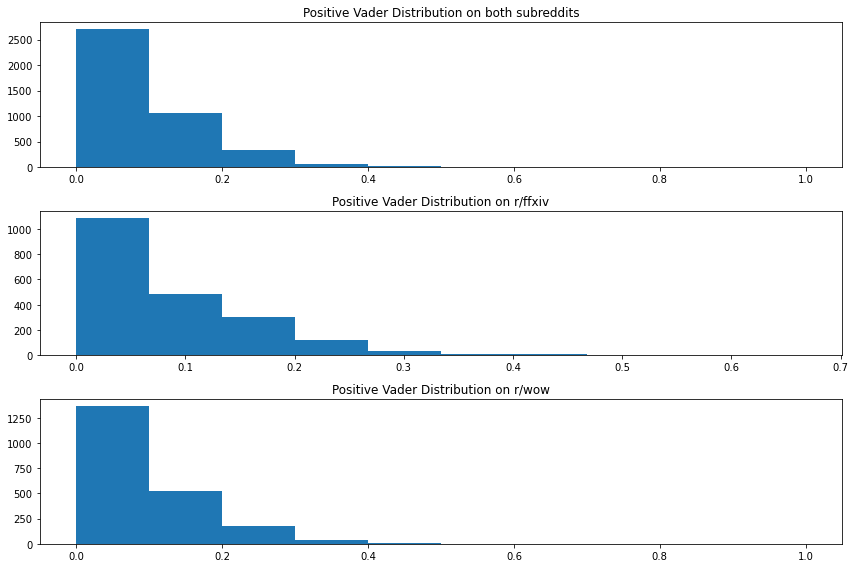

In [102]:
plt.subplot(311)
plt.title('Positive Vader Distribution on both subreddits')
plt.hist(df['self_text_vader_pos']);
plt.subplot(312)
plt.title('Positive Vader Distribution on r/ffxiv')
plt.hist(df.loc[df['is_on_ffxiv'] == 1]['self_text_vader_pos'])
plt.subplot(313)
plt.title('Positive Vader Distribution on r/wow')
plt.hist(df.loc[df['is_on_ffxiv'] == 0]['self_text_vader_pos'])
plt.tight_layout(rect = (2,2,4,4));

Much like before, very very similar distributions.

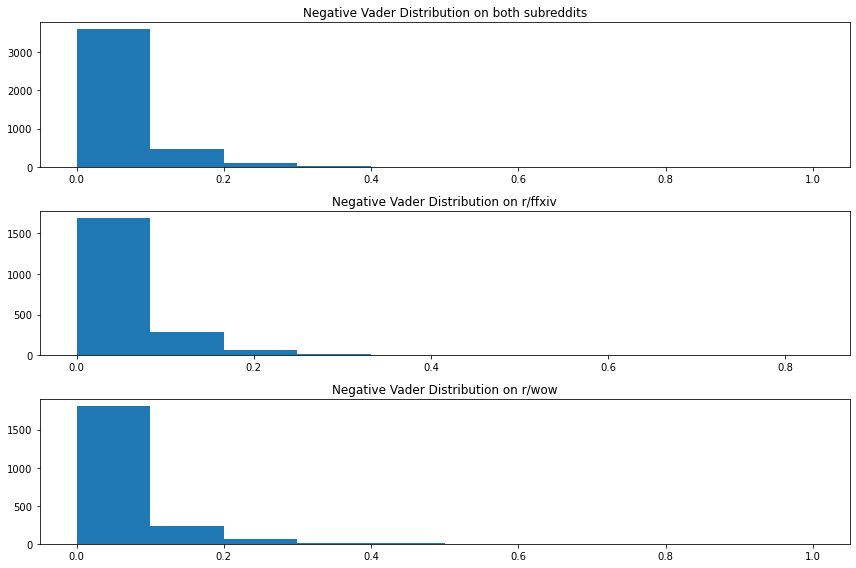

In [103]:
plt.subplot(311)
plt.title('Negative Vader Distribution on both subreddits')
plt.hist(df['self_text_vader_neg']);
plt.subplot(312)
plt.title('Negative Vader Distribution on r/ffxiv')
plt.hist(df.loc[df['is_on_ffxiv'] == 1]['self_text_vader_neg'])
plt.subplot(313)
plt.title('Negative Vader Distribution on r/wow')
plt.hist(df.loc[df['is_on_ffxiv'] == 0]['self_text_vader_neg'])
plt.tight_layout(rect = (2,2,4,4));

More of the same.

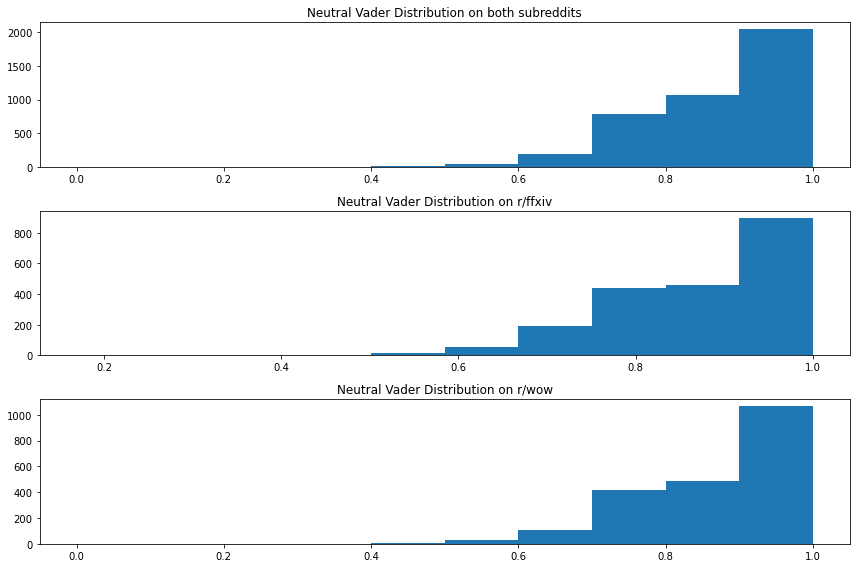

In [104]:
plt.subplot(311)
plt.title('Neutral Vader Distribution on both subreddits')
plt.hist(df['self_text_vader_neu']);
plt.subplot(312)
plt.title('Neutral Vader Distribution on r/ffxiv')
plt.hist(df.loc[df['is_on_ffxiv'] == 1]['self_text_vader_neu'])
plt.subplot(313)
plt.title('Neutral Vader Distribution on r/wow')
plt.hist(df.loc[df['is_on_ffxiv'] == 0]['self_text_vader_neu'])
plt.tight_layout(rect = (2,2,4,4));

And again, more of the same, but traveling in the other direction.

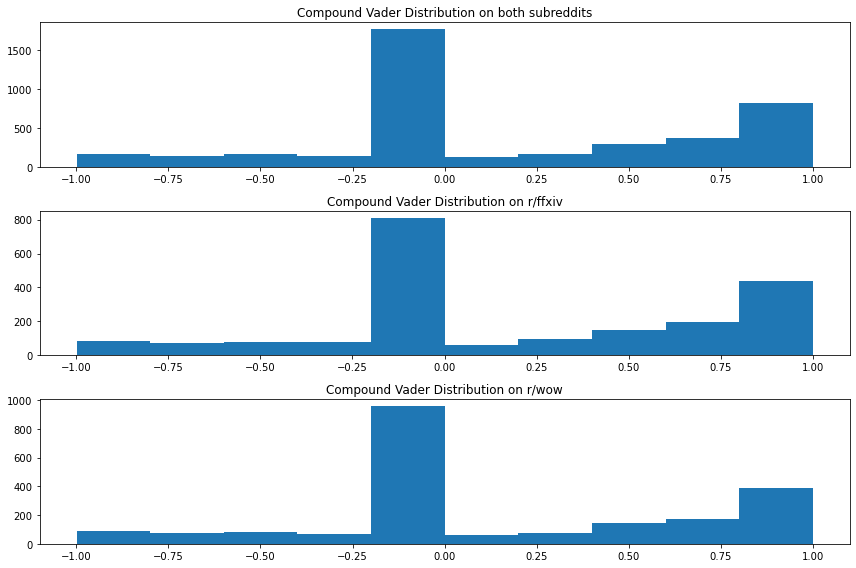

In [105]:
plt.subplot(311)
plt.title('Compound Vader Distribution on both subreddits')
plt.hist(df['self_text_vader_compound']);
plt.subplot(312)
plt.title('Compound Vader Distribution on r/ffxiv')
plt.hist(df.loc[df['is_on_ffxiv'] == 1]['self_text_vader_compound'])
plt.subplot(313)
plt.title('Compound Vader Distribution on r/wow')
plt.hist(df.loc[df['is_on_ffxiv'] == 0]['self_text_vader_compound'])
plt.tight_layout(rect = (2,2,4,4));

More of the same.  I might just drop all of these.

Next, let's examine those distributions in our titles.

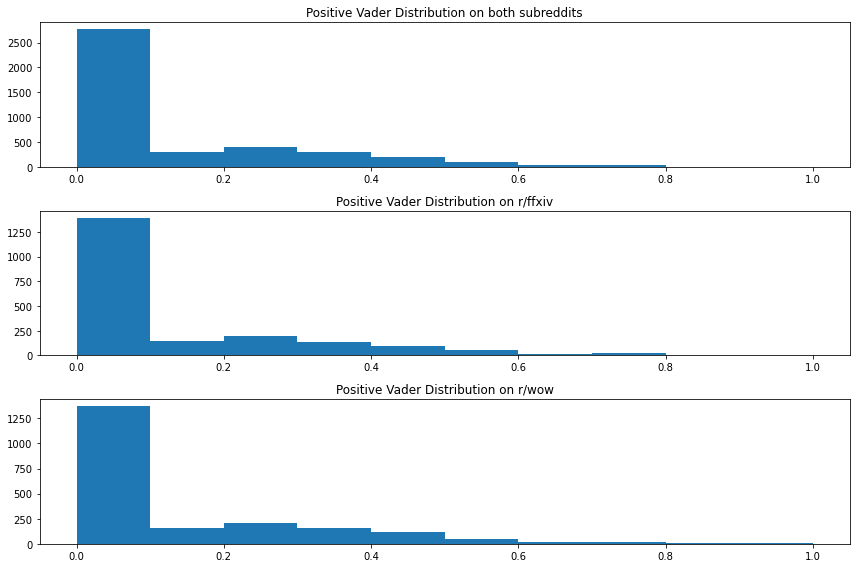

In [106]:
plt.subplot(311)
plt.title('Positive Vader Distribution on both subreddits')
plt.hist(df['title_vader_pos']);
plt.subplot(312)
plt.title('Positive Vader Distribution on r/ffxiv')
plt.hist(df.loc[df['is_on_ffxiv'] == 1]['title_vader_pos'])
plt.subplot(313)
plt.title('Positive Vader Distribution on r/wow')
plt.hist(df.loc[df['is_on_ffxiv'] == 0]['title_vader_pos'])
plt.tight_layout(rect = (2,2,4,4));

Same distributions again.

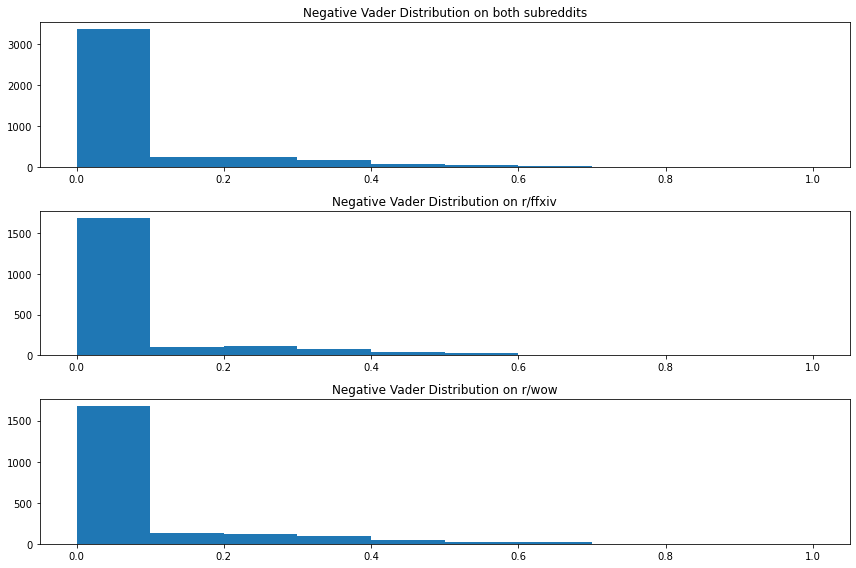

In [107]:
plt.subplot(311)
plt.title('Negative Vader Distribution on both subreddits')
plt.hist(df['title_vader_neg']);
plt.subplot(312)
plt.title('Negative Vader Distribution on r/ffxiv')
plt.hist(df.loc[df['is_on_ffxiv'] == 1]['title_vader_neg'])
plt.subplot(313)
plt.title('Negative Vader Distribution on r/wow')
plt.hist(df.loc[df['is_on_ffxiv'] == 0]['title_vader_neg'])
plt.tight_layout(rect = (2,2,4,4));

And again.

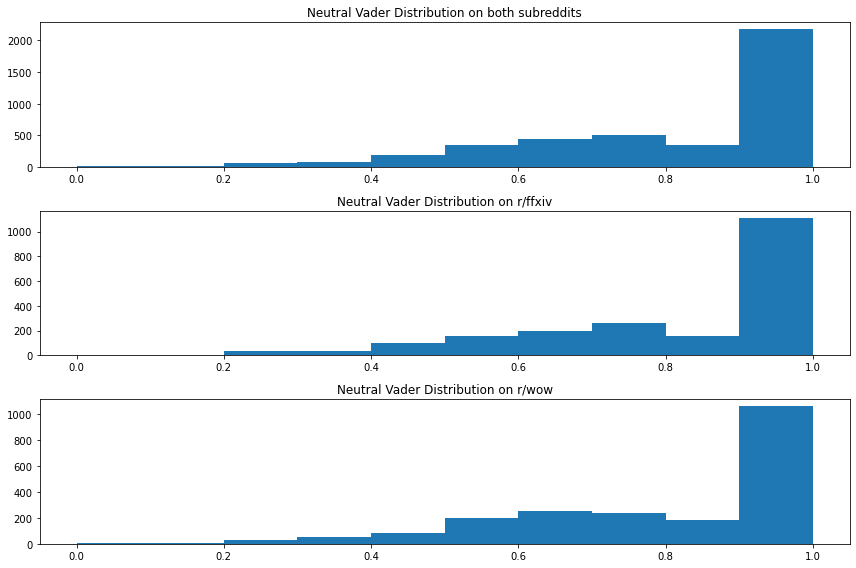

In [108]:
plt.subplot(311)
plt.title('Neutral Vader Distribution on both subreddits')
plt.hist(df['title_vader_neu']);
plt.subplot(312)
plt.title('Neutral Vader Distribution on r/ffxiv')
plt.hist(df.loc[df['is_on_ffxiv'] == 1]['title_vader_neu'])
plt.subplot(313)
plt.title('Neutral Vader Distribution on r/wow')
plt.hist(df.loc[df['is_on_ffxiv'] == 0]['title_vader_neu'])
plt.tight_layout(rect = (2,2,4,4));

And again.

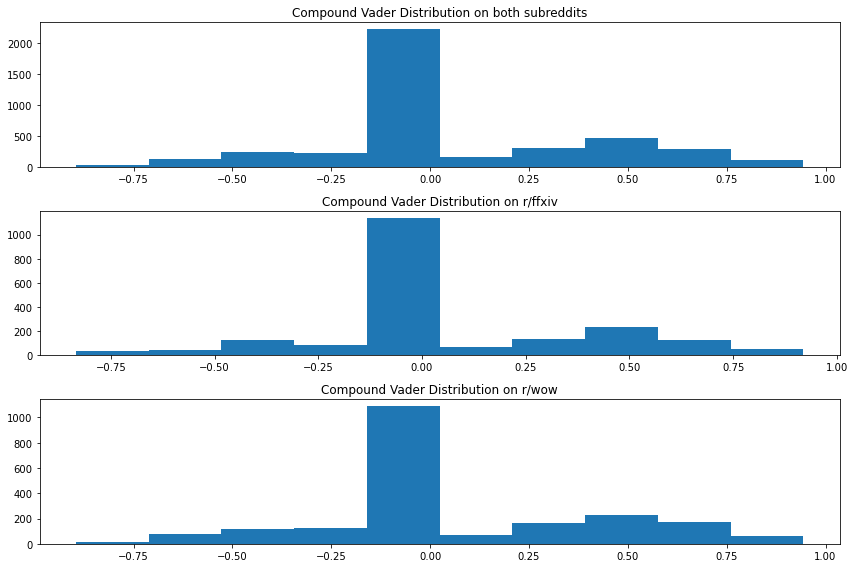

In [109]:
plt.subplot(311)
plt.title('Compound Vader Distribution on both subreddits')
plt.hist(df['title_vader_compound']);
plt.subplot(312)
plt.title('Compound Vader Distribution on r/ffxiv')
plt.hist(df.loc[df['is_on_ffxiv'] == 1]['title_vader_compound'])
plt.subplot(313)
plt.title('Compound Vader Distribution on r/wow')
plt.hist(df.loc[df['is_on_ffxiv'] == 0]['title_vader_compound'])
plt.tight_layout(rect = (2,2,4,4));

And again!  Somehow even the compound distributions are the same concerning our titles.  It appears that none of this data will make our model more effective, since none if it is indicative towards one class or the other.  I'll be dropping all these columns except for the Title length, as there may still be some value in that feature.

In [110]:
df.drop(columns = [
    'self_text_len',
    'self_text_vader_pos',
    'self_text_vader_neu',
    'self_text_vader_neg',
    'self_text_vader_compound',
    'title_vader_pos',
    'title_vader_neg',
    'title_vader_neu',
    'title_vader_compound'], 
    inplace = True)

## Vectorizing and Modeling

My data is clean, I've pruned and tweaked my features, my words are ready for vectorization.  It's time to vectorize and model!  I want to get a look at what our model looks like with raw Count Vectorization AND TFIDF Vectorization, so I'll be setting up four models: two for my CVEC data, and two for TFIDF data.

In [125]:
#creates the Count Vectorized self text column
self_text_cvec = CountVectorizer(stop_words = 'english', min_df=3)
self_text_cvec.fit(df['stemmed_self_text'])
self_text_words = pd.DataFrame(self_text_cvec.transform(df['stemmed_self_text']).todense(),columns = self_text_cvec.get_feature_names())
#creates the Count Vectorized title column
title_cvec = CountVectorizer(stop_words = 'english')
title_cvec.fit(df['stemmed_title'])
title_words = pd.DataFrame(title_cvec.transform(df['stemmed_title']).todense(),columns = title_cvec.get_feature_names())
#pushes the two columns together, while dropping the words that leak too much information to our model
cvec_df = pd.concat([title_words.drop(columns = ['wow','ffxiv','warcraft','final', 'xiv']), self_text_words.drop(columns = [ 'wow','ffxiv','warcraft','final', 'xiv']), df.drop(columns = ['stemmed_self_text','stemmed_title'])], axis = 1)
#drop all the single word columns that don't provide value, such as chunks of urls and those pesky 'notatextpost' values
cvec_df.drop(columns = ['notatextpost', 'delet', 'http','titl', 'https','img', 'amp'], inplace = True)
#sums all the duplicate columns
cvec_df = cvec_df.sum(axis = 1, level = 0)
#let's set up pipelins so we can scale and fit at the same time
cvec_rf_pipe = Pipeline([('scaler', StandardScaler()),('ran_for', RandomForestClassifier())])
#now for splitting our data into test and train
cvec_X = cvec_df.drop(columns = 'is_on_ffxiv')
cvec_y = cvec_df['is_on_ffxiv']
cvec_X_train, cvec_X_test, cvec_y_train, cvec_y_test = train_test_split(cvec_X,cvec_y, random_state = 42)
#random forest first
cvec_rf_pipe.fit(cvec_X_train, cvec_y_train)
#baseline!  We can treat this baseline as accurate for both the CVEC and TVEC models, as the target is unmodified by the vectorization.
print('The baseline score for the data is:',1 - cvec_y.mean())
#printing our scores as we go, and I will compare them all when this cell is finished running.
print('The CVEC Random Forest training score is:', cvec_rf_pipe.score(cvec_X_train, cvec_y_train))
print('The CVEC Random Forest testing score is:', cvec_rf_pipe.score(cvec_X_test, cvec_y_test))
#now for the extra trees, scaler included
cvec_extra_pipe = Pipeline([('scaler', StandardScaler()),('extra_trees', ExtraTreesClassifier())])
cvec_extra_pipe.fit(cvec_X_train, cvec_y_train)
print('The CVEC Extra Trees training score is:', cvec_extra_pipe.score(cvec_X_train, cvec_y_train))
print('The CVEC Extra Trees testing score is:', cvec_extra_pipe.score(cvec_X_test, cvec_y_test))

#from here on out, it's the same sequence of events as above, just applied with TFIDF instead
self_text_tvec = TfidfVectorizer(stop_words = 'english',min_df = .01)
self_text_tvec.fit(df['stemmed_self_text'])
self_text_tvec_words = pd.DataFrame(self_text_tvec.transform(df['stemmed_self_text']).todense(),columns = self_text_tvec.get_feature_names())
title_tvec = TfidfVectorizer(stop_words = 'english')
title_tvec.fit(df['stemmed_title'])
title_tvec_words = pd.DataFrame(title_tvec.transform(df['stemmed_title']).todense(),columns = title_tvec.get_feature_names())
tvec_df = pd.concat([title_tvec_words, self_text_tvec_words, df.drop(columns = ['stemmed_self_text','stemmed_title'])], axis = 1)
tvec_df = tvec_df.sum(axis = 1, level = 0)
tvec_X = tvec_df.drop(columns = 'is_on_ffxiv')
tvec_y = tvec_df['is_on_ffxiv']
tvec_X_train, tvec_X_test, tvec_y_train, tvec_y_test = train_test_split(tvec_X,tvec_y, random_state = 42)
tvec_rf_pipe = Pipeline([('scaler', StandardScaler()),('ran_for', RandomForestClassifier())])
tvec_rf_pipe.fit(tvec_X_train, tvec_y_train)
print('The TVEC Random Forest training score is:', tvec_rf_pipe.score(tvec_X_train, tvec_y_train))
print('The TVEC Random Forest testing score is:', tvec_rf_pipe.score(tvec_X_test, tvec_y_test))
tvec_extra_pipe = Pipeline([('scaler', StandardScaler()),('ran_for', ExtraTreesClassifier())])
tvec_extra_pipe.fit(tvec_X_train, tvec_y_train)
print('The TVEC Extra Trees training score is:', tvec_extra_pipe.score(tvec_X_train, tvec_y_train))
print('The TVEC Extra Trees testing score is:', tvec_extra_pipe.score(tvec_X_test, tvec_y_test))

The baseline score for the data is: 0.5059865900383143
The CVEC Random Forest training score is: 0.9987228607918263
The CVEC Random Forest testing score is: 0.8065134099616859
The CVEC Extra Trees training score is: 0.9987228607918263
The CVEC Extra Trees testing score is: 0.828544061302682
The TVEC Random Forest training score is: 0.9987228607918263
The TVEC Random Forest testing score is: 0.7816091954022989
The TVEC Extra Trees training score is: 0.9987228607918263
The TVEC Extra Trees testing score is: 0.8132183908045977


Of all the models I've tested, the CVEC Extra Trees, performs the best.  I'll be using that from here on out.

Now that I have our classification model ready, let's take a look at the confusion matrix and classification metrics.

In [126]:
pred = cvec_extra_pipe.predict(cvec_X_test)

In [127]:
print(confusion_matrix(cvec_y_test, pred, normalize = 'true'))

[[0.87475538 0.12524462]
 [0.21575985 0.78424015]]


In [128]:
print(classification_report(cvec_y_test, pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       511
           1       0.87      0.78      0.82       533

    accuracy                           0.83      1044
   macro avg       0.83      0.83      0.83      1044
weighted avg       0.83      0.83      0.83      1044



As far as our predictions go, we can see that it predicts positive (posts from r/FFXIV) correctly 78% of the time, and predicts negative (posts from r/WOW) 87% of the time.  The sensitivity, specificity, and f1 score are also around 83% as well.  All in all, a pretty solid model.

As a last point, let's see what the most effective features are.  This will be where we can gain some real inference usage, if there's any to be gained.

In [129]:
importances = cvec_extra_pipe.named_steps['extra_trees'].feature_importances_
print("Feature ranking:")
indices = np.argsort(importances)[::-1]
for f in range(cvec_X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]), cvec_X.columns[indices[f]])
#got this code from the sklearn site: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

Feature ranking:
1. feature 1997 (0.020566) legion
2. feature 5073 (0.010159) title_len
3. feature 3471 (0.007724) stormblood
4. feature 3146 (0.007299) se
5. feature 1627 (0.007087) heavensward
6. feature 375 (0.006863) blizzard
7. feature 1565 (0.005868) guild
8. feature 1877 (0.005732) job
9. feature 2359 (0.005699) mythic
10. feature 3204 (0.005238) shaman
11. feature 1728 (0.005187) hunter
12. feature 1028 (0.005024) druid
13. feature 202 (0.004881) artifact
14. feature 1257 (0.004796) fc
15. feature 1694 (0.004477) hord
16. feature 347 (0.004155) bfa
17. feature 2340 (0.004029) msq
18. feature 41 (0.003901) addon
19. feature 1480 (0.003647) glamour
20. feature 2739 (0.003614) priest
21. feature 2667 (0.003585) pld
22. feature 1712 (0.003570) hous
23. feature 1239 (0.003550) fantasi
24. feature 4010 (0.003533) wod
25. feature 3042 (0.003262) rogu
26. feature 1003 (0.003262) dragoon
27. feature 374 (0.003142) blizz
28. feature 1414 (0.003126) game
29. feature 1651 (0.003108) heroic

753. feature 147 (0.000320) aoe
754. feature 845 (0.000320) deal
755. feature 1407 (0.000319) fyi
756. feature 1449 (0.000319) general
757. feature 1401 (0.000319) funni
758. feature 2598 (0.000318) peak
759. feature 2887 (0.000317) reason
760. feature 1879 (0.000317) join
761. feature 2980 (0.000317) reshad
762. feature 179 (0.000317) arena
763. feature 3796 (0.000317) undercutt
764. feature 2388 (0.000317) nethershard
765. feature 3726 (0.000317) trash
766. feature 207 (0.000316) ashran
767. feature 2748 (0.000316) prize
768. feature 2498 (0.000316) opera
769. feature 3677 (0.000316) token
770. feature 3546 (0.000315) switch
771. feature 1176 (0.000315) everquest
772. feature 1562 (0.000315) guess
773. feature 3111 (0.000315) saw
774. feature 3117 (0.000314) scale
775. feature 1303 (0.000314) finish
776. feature 3281 (0.000314) singl
777. feature 465 (0.000314) build
778. feature 694 (0.000314) concern
779. feature 3319 (0.000314) small
780. feature 901 (0.000313) destroy
781. featur

1503. feature 2163 (0.000113) master
1504. feature 1420 (0.000113) gametim
1505. feature 4020 (0.000112) word
1506. feature 1855 (0.000112) isl
1507. feature 1371 (0.000112) frankfurt
1508. feature 1525 (0.000112) grab
1509. feature 937 (0.000112) disabl
1510. feature 1391 (0.000112) frustrat
1511. feature 1771 (0.000112) immedi
1512. feature 1526 (0.000111) grand
1513. feature 3652 (0.000111) til
1514. feature 2613 (0.000111) perform
1515. feature 2128 (0.000111) major
1516. feature 3474 (0.000111) stormrag
1517. feature 1458 (0.000111) ghostcrawl
1518. feature 3270 (0.000111) silver
1519. feature 1637 (0.000111) hell
1520. feature 3680 (0.000111) toll
1521. feature 2256 (0.000111) minor
1522. feature 2732 (0.000110) press
1523. feature 6 (0.000110) absolut
1524. feature 19 (0.000110) accuraci
1525. feature 1494 (0.000110) gmt
1526. feature 3942 (0.000110) water
1527. feature 2562 (0.000110) pano
1528. feature 2483 (0.000109) oh
1529. feature 4415 (0.000109) energi
1530. feature 1773 

2253. feature 4717 (0.000043) paper
2254. feature 2408 (0.000043) nidhogg
2255. feature 2590 (0.000043) pattern
2256. feature 896 (0.000042) desolac
2257. feature 1619 (0.000042) health
2258. feature 2964 (0.000042) replac
2259. feature 3134 (0.000042) scratch
2260. feature 3936 (0.000042) warr
2261. feature 2015 (0.000042) lfg
2262. feature 1252 (0.000042) father
2263. feature 887 (0.000042) deplet
2264. feature 353 (0.000042) biggest
2265. feature 4713 (0.000042) pair
2266. feature 1776 (0.000042) impact
2267. feature 3992 (0.000042) wind
2268. feature 3183 (0.000042) seri
2269. feature 4610 (0.000042) lone
2270. feature 1417 (0.000042) gamer
2271. feature 3309 (0.000042) sleev
2272. feature 315 (0.000041) battlenet
2273. feature 854 (0.000041) decad
2274. feature 3886 (0.000041) vid
2275. feature 1577 (0.000041) hack
2276. feature 3766 (0.000041) ty
2277. feature 2936 (0.000041) reinhardt
2278. feature 3255 (0.000041) shroud
2279. feature 4558 (0.000041) inde
2280. feature 1373 (0.0

3003. feature 4195 (0.000017) belief
3004. feature 3202 (0.000017) shaken
3005. feature 3811 (0.000017) ungarmax
3006. feature 638 (0.000017) clutch
3007. feature 4353 (0.000017) dick
3008. feature 1987 (0.000017) leatherwork
3009. feature 95 (0.000017) alloc
3010. feature 3237 (0.000017) shockobo
3011. feature 1317 (0.000017) fleet
3012. feature 2967 (0.000017) repres
3013. feature 1585 (0.000017) halloween
3014. feature 4157 (0.000017) archaic
3015. feature 356 (0.000017) birb
3016. feature 1107 (0.000017) emoji
3017. feature 4328 (0.000017) da
3018. feature 1993 (0.000017) legaia
3019. feature 3664 (0.000017) titanforg
3020. feature 1893 (0.000017) kannagi
3021. feature 4394 (0.000017) durat
3022. feature 4833 (0.000017) satisfi
3023. feature 3303 (0.000017) skylar
3024. feature 4674 (0.000017) needless
3025. feature 1080 (0.000017) ele
3026. feature 2789 (0.000017) pst
3027. feature 2197 (0.000017) megathread
3028. feature 5052 (0.000017) wifi
3029. feature 1191 (0.000017) execut
3

3752. feature 2941 (0.000006) relaps
3753. feature 3402 (0.000006) spit
3754. feature 4255 (0.000006) capabl
3755. feature 1892 (0.000006) kalimdor
3756. feature 3857 (0.000006) valuabl
3757. feature 1573 (0.000006) guo
3758. feature 762 (0.000006) crabthunderfuri
3759. feature 1606 (0.000006) haustvald
3760. feature 980 (0.000006) doma
3761. feature 2241 (0.000006) migrat
3762. feature 2004 (0.000006) lesser
3763. feature 2503 (0.000006) oppress
3764. feature 4192 (0.000006) bed
3765. feature 433 (0.000006) breakpoint
3766. feature 482 (0.000006) buyer
3767. feature 508 (0.000006) car
3768. feature 884 (0.000006) deneb
3769. feature 3208 (0.000006) shanti
3770. feature 3302 (0.000006) skychas
3771. feature 5 (0.000006) absent
3772. feature 4529 (0.000006) hearth
3773. feature 4174 (0.000006) attract
3774. feature 4532 (0.000006) hesit
3775. feature 3658 (0.000006) tina
3776. feature 4777 (0.000006) radeon
3777. feature 4720 (0.000006) partner
3778. feature 1809 (0.000006) innkeep
3779

4502. feature 1917 (0.000000) kilrogg
4503. feature 1652 (0.000000) hershey
4504. feature 4958 (0.000000) tickl
4505. feature 1903 (0.000000) kev
4506. feature 3503 (0.000000) subrac
4507. feature 59 (0.000000) afflicti
4508. feature 1897 (0.000000) kazzak
4509. feature 3494 (0.000000) student
4510. feature 1664 (0.000000) highlord
4511. feature 962 (0.000000) diu
4512. feature 1668 (0.000000) hill
4513. feature 1941 (0.000000) kungan
4514. feature 1944 (0.000000) kyubi
4515. feature 1946 (0.000000) labyrinth
4516. feature 969 (0.000000) doc
4517. feature 2000 (0.000000) lego
4518. feature 1998 (0.000000) legit
4519. feature 1620 (0.000000) healthston
4520. feature 944 (0.000000) disconect
4521. feature 1982 (0.000000) leagu
4522. feature 1981 (0.000000) leaderboard
4523. feature 1972 (0.000000) laucher
4524. feature 1626 (0.000000) heavensfal
4525. feature 4907 (0.000000) stood
4526. feature 1957 (0.000000) lamia
4527. feature 3457 (0.000000) stereotyp
4528. feature 4911 (0.000000) st

And there we have it: the language that is most effective at discerning between the two subreddits is language that often deals with specific properties of the relevant games. 

Legion, BFA, and Shadowlands are all WOW Expansions, and Shadowlands and Stormblood are FFXIV expansions.  Mythic, classic, and guild are all heavily WOW-centric terms, while job, FC, and glamour are all FFXIV-centric.  Word-wise, it doesn't seem that NLP will tell us anything that a person with domain knowledge doesn't already know.  

However, our title length feature managed to come in 2nd, which shows that posts with long-winded titles are far more likely to be found on r/wow than r/ffxiv.

Ultimately, this model could be useful for applying to a larger program that takes in post text and then decides whether the poster is a current player of FFXIV or a player of it's largest competitor, WOW, but this would only be efficient if the program were trying to work through reams of posts over a long time.  On a post by post basis, an individual with enough knowledge about either game would be just as accurate, if not more so.  The real benefit here would likely be speed.  
In conclusion, I would not recommend the use of this model over individual post analysis, and I do not recommend it be used to try to match languge with users to seem more familiar to them.  